In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import geopandas as gpd
from geopandas.tools import geocode

import folium 
from folium.plugins import HeatMap

import matplotlib.pyplot as plt
from matplotlib_venn import venn2

Setup successful!


# An exploratory attempt to tap into Steam user tendencies (data obtained in 2016)
**109 MILLION GAMERS***

**716 MILLION GAMES***

**1.1 MILLION YEARS OF PLAYTIME***

Reference:

Database retrieved reformated and reuploaded to Kaggle from the [researcher's published site][1], where you can download their raw SQL. 

A dataset collected and analyzed for the **2016** ACM Internet Measurement Conference article by Mark O'Neill, Justin Wu, Elham Vaziripour, and Daniel Zappala
see [the paper][2].

[1]: https://steam.internet.byu.edu/
[2]: https://steam.internet.byu.edu/oneill-condensing-steam.pdf

*the numbers were claimed by the authors of publication, although as we see later - data exploration reveals otherwise
### I would love to work with newer data, so hit me up with suggestions :)



## Data
Importing, appending some which was split between tables in the DB.

In [2]:
#GAMES_DAILY	steamid	appid	playtime_forever
playtime_data_link_1 = "../input/steam-playtime-complete/games_1_sample.csv"
playtime_data_link_2 = "../input/steam-playtime-complete/games_2_sample.csv"
playtime = pd.read_csv(playtime_data_link_1)
playtime.append(pd.read_csv(playtime_data_link_2))
playtime_sample_multiplier = 33
#GAMES_PUBLISHERS	appid	Publisher
product_publishers_data_link = "../input/steam-games-publishers/game_publishers.csv"
product_publishers = pd.read_csv(product_publishers_data_link)
product_publishers = product_publishers.dropna()
#GAMES_DEVELOPERS	appid	Developer
product_developers_data_link = "../input/game-developers/game_developers.csv"
product_developers = pd.read_csv(product_developers_data_link)
#GAMES_GENRES	appid	Genre
genres_data_link = "../input/steam-games-genres/game_genres.csv"
genres = pd.read_csv(genres_data_link)
#APP_ID_INFO	appid	Title	Type	Price	Release_Date	Rating	Required_Age	Is_Multiplayer
products_data_link = "../input/app-id-info/app_id_info.csv"
products = pd.read_csv(products_data_link)

**All tables are fully exported, except "playtime" data, it's a sample of 3%**

Inside the database researchers provide three tables about player play-times. One table, is the innitial crawl, another - a subsequent larger crawl. The third one is a daily crawl of a selected subset of players. In this notebook we would need the first and subsequent data, but these tables are so large, that kaggle/jupyter wont run for various reasons. When I tried, I got the error "out of memory" and my PC build has got some serious power! Therefore I took a sample of 3%, which barely scraches the surface, but the conclusions could still be acurate enough, just have to multiply them by 33.

The provided data was in MySQL script format, which introduced a weird problem - SQL Workbench could not export large tables into CSV, so I came up with a solution to write a python script.

It simply takes out data in chunks and appends to a file. Since SQL queries slow down logarithmicly when requesting further in the table via "LIMIT x, y", a colleague proposed to make a copy of a table and keep deleting after an amount of requests (I chose 350k rows) were saved into csv.

In [3]:
# slice products by type
product_types = products.Type.unique()
games = products[products["Type"] == "game"]
dlcs = products[products["Type"] == "dlc"]
mods = products[products["Type"] == "mod"]
print(product_types)

['dlc' 'game' 'demo' 'video' 'mod' 'hardware']


## Releases vs Sales
Does more products released mean exponential popularity or a more linear one?
* Make a dataframe on each Publisher / Developer;
* Count how many products and titles each has, how many units users own;
* Does Released title count increase owner cound linearly or is there a hotspot?
* How many developers on steam self-publish?

In [4]:
product_publishers = product_publishers.dropna()
playtime_games = playtime[playtime["appid"].isin(games.appid)]
playtime_games_groups = playtime_games.groupby(['appid'])
playtime_dlcs = playtime[playtime["appid"].isin(dlcs.appid)]
playtime_dlcs_groups = playtime_dlcs.groupby(['appid'])

* Developer

In [5]:
# Making tables for Games product type
product_developers_games = product_developers[product_developers["appid"].isin(games.appid)]
deverloper_games_groups = product_developers_games.groupby(["Developer"])
developers_games = pd.DataFrame({"Developer":product_developers_games.Developer.unique()})
developers_games["Owners"] = product_developers_games.appid.apply(lambda x: len(playtime_games_groups.groups[x]) * playtime_sample_multiplier if x in playtime_games_groups.groups.keys() else 0)
developers_games["Releases"] = product_developers_games.Developer.apply(lambda x: len(deverloper_games_groups.groups[x]))
developers_games = developers_games[developers_games["Owners"]  > 0]

In [6]:
# Making tables for DLCs product type
product_developers_dlcs = product_developers[product_developers["appid"].isin(dlcs.appid)]
deverloper_dlcs_groups = product_developers_dlcs.groupby(["Developer"])
developers_dlcs = pd.DataFrame({"Developer":product_developers_dlcs.Developer.unique()})
developers_dlcs["Owners"] = product_developers_dlcs.appid.apply(lambda x: len(playtime_dlcs_groups.groups[x]) * playtime_sample_multiplier if x in playtime_dlcs_groups.groups.keys() else 0)
developers_dlcs["Releases"] = product_developers_dlcs.Developer.apply(lambda x: len(deverloper_dlcs_groups.groups[x]))
developers_dlcs = developers_dlcs.dropna()
developers_dlcs = developers_dlcs[developers_dlcs["Owners"]  > 0]

Let's see how DLC's sales relate to Game sales visualy.

Text(0.5, 1.0, 'Games Sales')

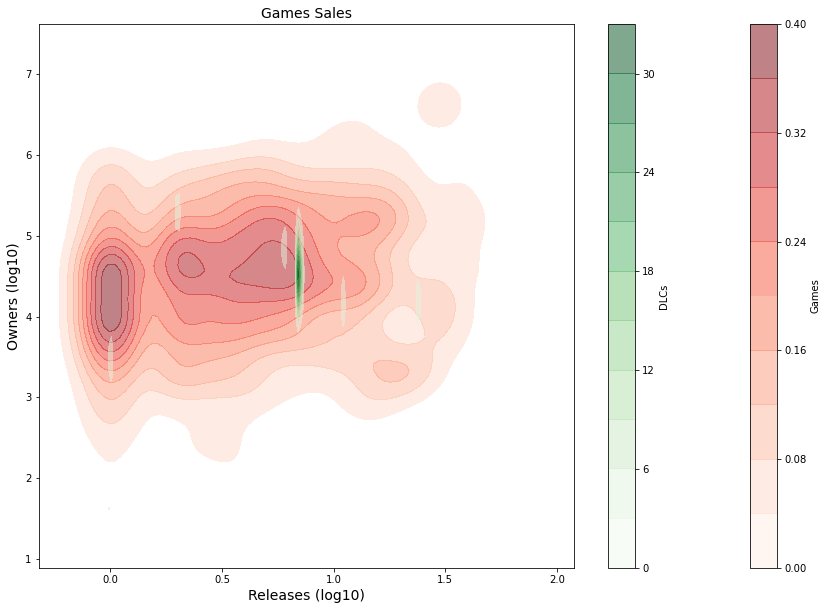

In [7]:
plt.figure(figsize=(15,10))
sns.kdeplot(np.log10(developers_games['Releases']), np.log10(developers_games['Owners']), cmap="Reds", shade=True, shade_lowest=False, cbar = True, cbar_kws = {"label":"Games"}, alpha = 0.5) #, "shrink":0.7
sns.kdeplot(np.log10(developers_dlcs['Releases']), np.log10(developers_dlcs['Owners']), cmap="Greens", shade=True, shade_lowest=False, cbar = True, cbar_kws = {"label":"DLCs"}, alpha = 0.5)
plt.xlabel("Releases (log10)", fontsize = 14)
plt.ylabel("Owners (log10)", fontsize = 14)
plt.title("Games Sales", fontsize = 14)

In [8]:
developers_dlcs[developers_dlcs["Owners"] > 10000].sort_values("Releases", ascending = False).head()

,Developer,Owners,Releases
1168,Morvan,15279.0,24.0
1169,Antinomia,15279.0,11.0
363,Demiurge Studios,14223.0,7.0
364,Stainless games,105237.0,7.0
365,Axis Game Factory LLC,49467.0,7.0


* Publisher

In [9]:
# Making tables for Games product type for publishers
product_publishers_games = product_publishers[product_publishers["appid"].isin(games.appid)]
publishers_games_groups = product_publishers_games.groupby(["Publisher"])
publishers_games = pd.DataFrame({"Publisher":product_publishers_games.Publisher.unique()})
publishers_games["Owners"] = product_publishers_games.appid.apply(lambda x: len(playtime_games_groups.groups[x]) * playtime_sample_multiplier if x in playtime_games_groups.groups.keys() else 0)
publishers_games["Releases"] = product_publishers_games.Publisher.apply(lambda x: len(publishers_games_groups.groups[x]))
publishers_games = publishers_games[publishers_games["Owners"]  > 0]

In [10]:
# Making tables for DLCs of publishers
product_publishers_dlcs = product_publishers[product_publishers["appid"].isin(dlcs.appid)]
publishers_dlcs_groups = product_publishers_dlcs.groupby(["Publisher"])
publishers_dlcs = pd.DataFrame({"Publisher":product_publishers_dlcs.Publisher.unique()})
publishers_dlcs["Owners"] = product_publishers_dlcs.appid.apply(lambda x: len(playtime_dlcs_groups.groups[x]) * playtime_sample_multiplier if x in playtime_dlcs_groups.groups.keys() else 0)
publishers_dlcs["Releases"] = product_publishers_dlcs.Publisher.apply(lambda x: len(publishers_dlcs_groups.groups[x]))
publishers_dlcs = publishers_dlcs.dropna()
publishers_dlcs = publishers_dlcs[publishers_dlcs["Owners"]  > 0]

In [11]:
publishers_dlcs.nlargest(10, "Releases")

,Publisher,Owners,Releases
380,Slightly Mad Studios,14223.0,7.0
381,Full Control,105237.0,7.0
382,Digital Confectioners,49467.0,7.0
408,Microsoft Game Studios,196647.0,1.0


We see here that publishers do not mark their products as DLCs almost all of the time. So sadly, we cannot evaluate differences, even if there aren't any.

Instead, let's compare developers vs publishers in game-only release numbers.

Text(0.5, 1.0, 'Games Sales')

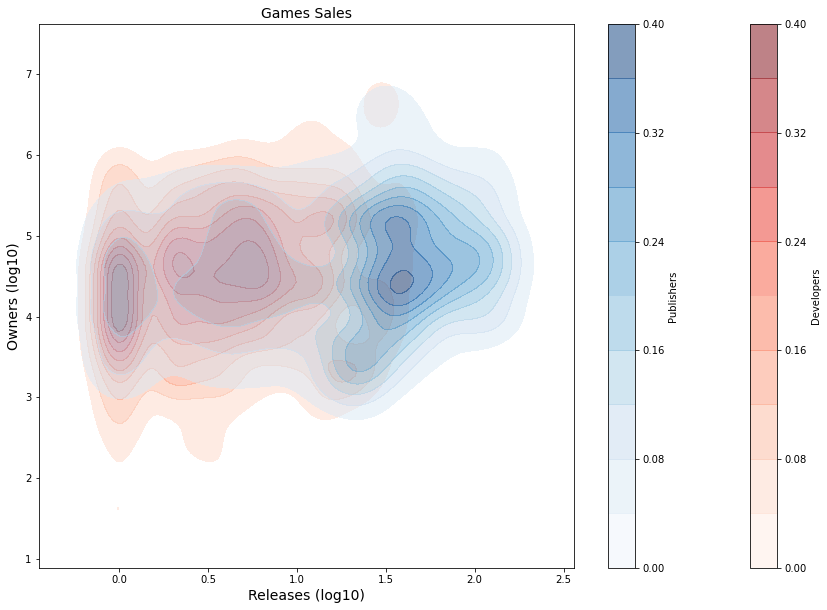

In [12]:
plt.figure(figsize=(15,10))

kde2 = sns.kdeplot(np.log10(developers_games['Releases']), np.log10(developers_games['Owners']), cmap="Reds", shade=True, shade_lowest=False, cbar = True, cbar_kws = {"label":"Developers"}, alpha = 0.5) #, "shrink":0.7
sns.kdeplot(np.log10(publishers_games['Releases']), np.log10(publishers_games['Owners']), cmap="Blues", shade=True, shade_lowest=False, cbar = True, cbar_kws = {"label":"Publishers"}, alpha = 0.5)
#kde2.set(xlabel='Owners (log10)', ylabel='Releases (log10)', title = "Game Sales")
plt.xlabel("Releases (log10)", fontsize = 14)
plt.ylabel("Owners (log10)", fontsize = 14)
plt.title("Games Sales", fontsize = 14)

* As seen from this nice overlay map, there's a slight advantage of having more releases both as a developer and publisher.
* Publishers also tend to have more game releases compared to developers alone, which completely makes sense!
* There is a lot overlap too, these are likely self-publishing developers.

* Self-published developers - in the overlaping circle:

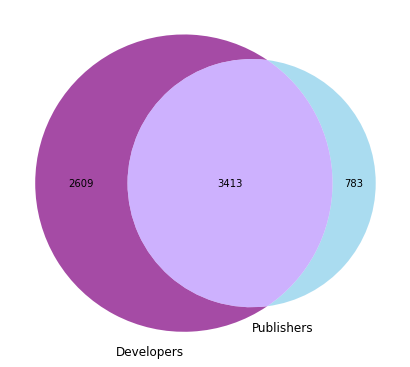

In [13]:
v = venn2([set(product_developers_games.Developer), set(product_publishers_games.Publisher)], set_colors=("purple", "skyblue"), alpha = 0.7)
v.get_label_by_id('A').set_text('Developers')
v.get_label_by_id('B').set_text('Publishers')

fig = plt.gcf()
fig.set_size_inches(12.5, 6.5)
fig.savefig('test2png.png', dpi=100)

plt.show()

We can see that more than half of developers self-publish games. There are 783 publishers, who do not develop themselves, instead only release other developer games on Steam.

## Top Market Players
For each dev and publisher:
* count released products (top 10 highest producers/publishers)
* calculate total entity value (top 10 highest all-time earners)
* calculate the average price of their products (top 10 luxurious)

### Developers

In [14]:
# To display dables in a tidier manner:
from IPython.core.display import HTML
#._repr_html_()
def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table.to_html(index=False) + '</td>' for table in table_list]) +
        '</tr></table>'
    )

In [15]:
playtime_groups = playtime.groupby(['appid'])

In [16]:
product_developers["Owners"] = product_developers.appid.apply(lambda x: len(playtime_groups.get_group(x) * playtime_sample_multiplier) if x in playtime_groups.groups.keys() else 0)
product_developers = product_developers[product_developers["Owners"] > 0]
product_developers["Price"] = product_developers.appid.apply(lambda x: (products.loc[products["appid"] == x, ["Price"]].iloc[0].Price))
product_developers["Revenue"] = product_developers.appid.apply(lambda x: (products.loc[products["appid"] == x, ["Price"]].iloc[0].Price) * (product_developers.loc[product_developers["appid"] == x, ["Owners"]].iloc[0].Owners))

In [17]:
product_publishers["Owners"] = product_publishers.appid.apply(lambda x: len(playtime_groups.get_group(x) * playtime_sample_multiplier) if x in playtime_groups.groups.keys() else 0)
product_publishers = product_publishers[product_publishers["Owners"] > 0]
product_publishers["Price"] = product_publishers.appid.apply(lambda x: (products.loc[products["appid"] == x, ["Price"]].iloc[0].Price))
product_publishers["Revenue"] = product_publishers.appid.apply(lambda x: (products.loc[products["appid"] == x, ["Price"]].iloc[0].Price) * (product_publishers.loc[product_publishers["appid"] == x, ["Owners"]].iloc[0].Owners))

In [18]:
dev_gr = product_developers.groupby(["Developer"])
dev_gr.size().sort_values(ascending=False).head()

Developer
Telltale Games        31
PopCap Games, Inc.    28
MumboJumbo            27
Valve                 26
Her Interactive       23
dtype: int64

Looks like Telltale was first by the amount of products released. RIP Telltale Games :(

In [19]:
product_developers['Total_Revenue'] = product_developers['Revenue'].groupby(product_developers['Developer']).transform('sum')
product_developers['Total_Owners'] = product_developers['Owners'].groupby(product_developers['Developer']).transform('sum')
product_developers = product_developers[product_developers["Total_Owners"] > 100]

product_publishers['Total_Revenue'] = product_publishers['Revenue'].groupby(product_publishers['Publisher']).transform('sum')
product_publishers['Total_Owners'] = product_publishers['Owners'].groupby(product_publishers['Publisher']).transform('sum')
product_publishers = product_publishers[product_publishers["Total_Owners"] > 100]

In [20]:
product_developers["Top_Product_Value"] = product_developers['Revenue'].groupby(product_developers['Developer']).transform('max')
product_publishers["Top_Product_Value"] = product_publishers['Revenue'].groupby(product_publishers['Publisher']).transform('max')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
publishers = pd.DataFrame({"Publisher":product_publishers.Publisher.unique()})
developers = pd.DataFrame({"Developer":product_developers.Developer.unique()})

developer_groups = product_developers.groupby(["Developer"])
developers["Releases"] = developer_groups.apply(lambda grp: grp.size)

developers["Total_Owners"] = developers.Developer.apply(lambda x: developer_groups.get_group(x).iloc[0].Total_Owners)
developers["Entity_value"] = developers.Developer.apply(lambda x: developer_groups.get_group(x).iloc[0].Total_Revenue)

publisher_groups = product_publishers.groupby(["Publisher"])
publishers["Releases"] = publisher_groups.apply(lambda grp: grp.size)
publishers["Total_Owners"] = publishers.Publisher.apply(lambda x: publisher_groups.get_group(x).iloc[0].Total_Owners)
publishers["Entity_value"] = publishers.Publisher.apply(lambda x: publisher_groups.get_group(x).iloc[0].Total_Revenue)

In [22]:
top_app_ids_dev = developers.Developer.apply(lambda x: product_developers.loc[product_developers.groupby(['Developer']).get_group(x)["Revenue"].idxmax()]["appid"])
developers["Top_Product_Name"] = top_app_ids_dev.apply(lambda x: products[products.appid == int(x)]["Title"].item()) #a heavy error - the equals item was of wrong type (str)
developers["Top_Product_Value"] = developers.Developer.apply(lambda x: developer_groups.get_group(x).iloc[0].Top_Product_Value)

In [23]:
top_app_ids_pub = publishers.Publisher.apply(lambda x: product_publishers.loc[product_publishers.groupby(['Publisher']).get_group(x)["Revenue"].idxmax()]["appid"])
publishers["Top_Product_Name"] = top_app_ids_pub.apply(lambda x: products[products.appid == int(x)]["Title"].item()) #a heavy error - the equals item was of wrong type (str)
publishers["Top_Product_Value"] = publishers.Publisher.apply(lambda x: publisher_groups.get_group(x).iloc[0].Top_Product_Value)

In [24]:
publishers

,Publisher,Releases,Total_Owners,Entity_value,Top_Product_Name,Top_Product_Value
0,Valve,NaN,3774493,32229271.15,Counter-Strike: Source,5358559.38
1,Mark Healey,NaN,911,9100.89,Rag Doll Kung Fu,9100.89
2,Tripwire Interactive,NaN,102873,1537156.12,Killing Floor,928455.54
3,Darklight Games,NaN,4571,0.00,Darkest Hour: Europe '44-'45,0.00
4,Ritual Entertainment,NaN,16422,164055.78,SiN Episodes: Emergence,55694.25
...,...,...,...,...,...,...
532,Mossmouth,NaN,250,3747.50,Spelunky,3747.50
533,Ian Campbell,NaN,316,1576.84,Bleed,1576.84
534,Greenheart Games,NaN,424,4235.76,Game Dev Tycoon,4235.76
535,Zen Studios,NaN,145,1448.55,CastleStorm,1448.55


In [25]:
#product_publishers.loc["Valve" == product_publishers.Publisher]

In [26]:
products[240 == products.appid]

,appid,Title,Type,Price,Release_Date,Rating,Required_Age,Is_Multiplayer
6179,240,Counter-Strike: Source,game,19.99,11/1/2004 0:00,88,0,1


### Top Developer Studios in Market

In [27]:
top_member_count = 10

In [28]:
high_prod_developers = developers.nlargest(top_member_count, "Releases")
high_value_developers = developers.nlargest(top_member_count, "Entity_value")
high_sale_dev = developers.nlargest(top_member_count, "Total_Owners")
multi_table([high_prod_developers[['Developer','Releases']], high_value_developers[['Developer','Entity_value']], high_sale_dev[['Developer','Total_Owners']]])

Developer,Releases
Developer,Entity_value
Valve,30543881.37
Aspyr (Mac),10313321.75
Treyarch,9538959.05
Infinity Ward,9043328.22
Feral Interactive (Mac),6168221.47
Relic Entertainment,5374559.09
Sledgehammer Games,4764928.47
Firaxis Games,4624722.69
The Creative Assembly,3508968.30


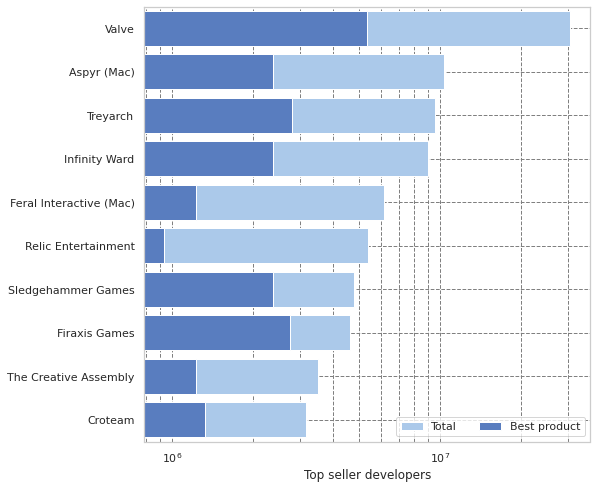

In [29]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(8, 8))
# First plot total value
sns.set_color_codes("pastel")
ent_val_graph = sns.barplot(x="Entity_value", y="Developer", data=high_value_developers, label="Total", color="b", orient='h')
#ent_val_graph.yaxis.tick_left()
# Plot earnings from highest bought product on top
sns.set_color_codes("muted")

top_prods_graph = sns.barplot(x="Top_Product_Value", y="Developer", data=high_value_developers, label="Best product", color="b", orient='h')
#top_prods_graph.yaxis.tick_right()

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="",xlabel="Top seller developers")
ax.set_xscale("log")
ax.grid(True,which="both",ls="--",c='gray')  
#sns.despine(left=True, bottom=True)
plt.show()

#perhaps could show the most valuable product on the right side?

### Top Publishers in Market

In [30]:
high_pub_publishers = publishers.nlargest(top_member_count, "Releases")
high_value_publishers = publishers.nlargest(top_member_count, "Entity_value")
high_sale_pub = publishers.nlargest(top_member_count, "Total_Owners")
multi_table([high_pub_publishers[['Publisher','Releases']], high_value_publishers[['Publisher','Entity_value']], high_sale_pub[['Publisher','Total_Owners']]])

Publisher,Releases
Publisher,Entity_value
Valve,32229271.15
Activision,19285282.70
SEGA,10431938.40
Aspyr (Mac),10405755.51
2K Games,8839254.09
Feral Interactive (Mac),6168221.47
Electronic Arts,6049415.57
Bethesda Softworks,4545394.30
Ubisoft,3632575.79


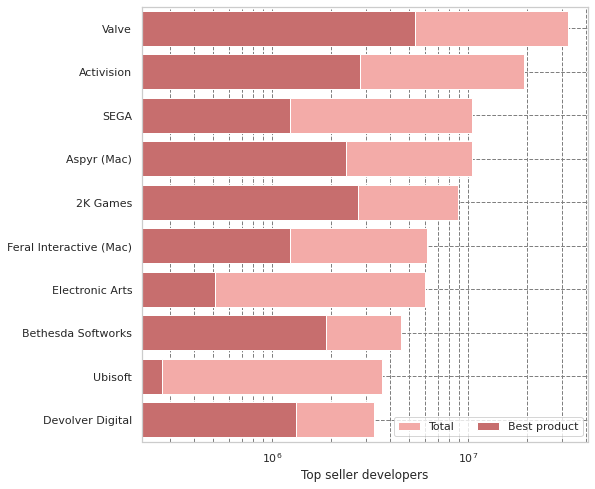

In [31]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(8, 8))
# First plot total value
sns.set_color_codes("pastel")
ent_val_graph = sns.barplot(x="Entity_value", y="Publisher", data=high_value_publishers, label="Total", color="r", orient='h')
#ent_val_graph.yaxis.tick_left()
# Plot earnings from highest bought product on top
sns.set_color_codes("muted")

top_prods_graph = sns.barplot(x="Top_Product_Value", y="Publisher", data=high_value_publishers, label="Best product", color="r", orient='h')
#top_prods_graph.yaxis.tick_right()

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="",xlabel="Top seller developers")
ax.set_xscale("log")
ax.grid(True,which="both",ls="--",c='gray')  
#sns.despine(left=True, bottom=True)
plt.show()

## Product value

* Draw popularity of products (total playtime) adjusted by the developer's release-time


* See mean game price monthly historical changes data



In [32]:
products['Playtime'] = playtime['playtime_forever'].groupby(playtime['appid']).transform('sum')

In [33]:
products["Release_Date"] = pd.to_datetime(products["Release_Date"])
products["Lifetime_Days"] = products.apply(lambda x: pd.Timedelta(pd.to_datetime("2016-12-31") - x["Release_Date"]).days, axis = 1)
#developers["Playtime"] = product_developers.apply(lambda x: ((products.loc[products["appid"] == x.appid, ["Playtime"]]) / (products.loc[products["appid"] == x.appid, ["Lifetime_Days"]])).sum(), axis = 1)

products["Owners"] = products.appid.apply(lambda x: len(playtime_groups.get_group(x)) if x in playtime_groups.groups.keys() else 0)
#products = products[products.Owners > 0]

Let's take products that are newer than the platform to make it more consistent and filter out zero playtimes (zero here means player owns the product, but has never played it. It is interesting data by itself, but not for the scope of this notebook).

In [34]:
products_non_zero = products[products.Playtime > 0]
p2000plus =  products_non_zero[products_non_zero["Release_Date"] > '2008-1-1']

(733042.0, 736330.0)

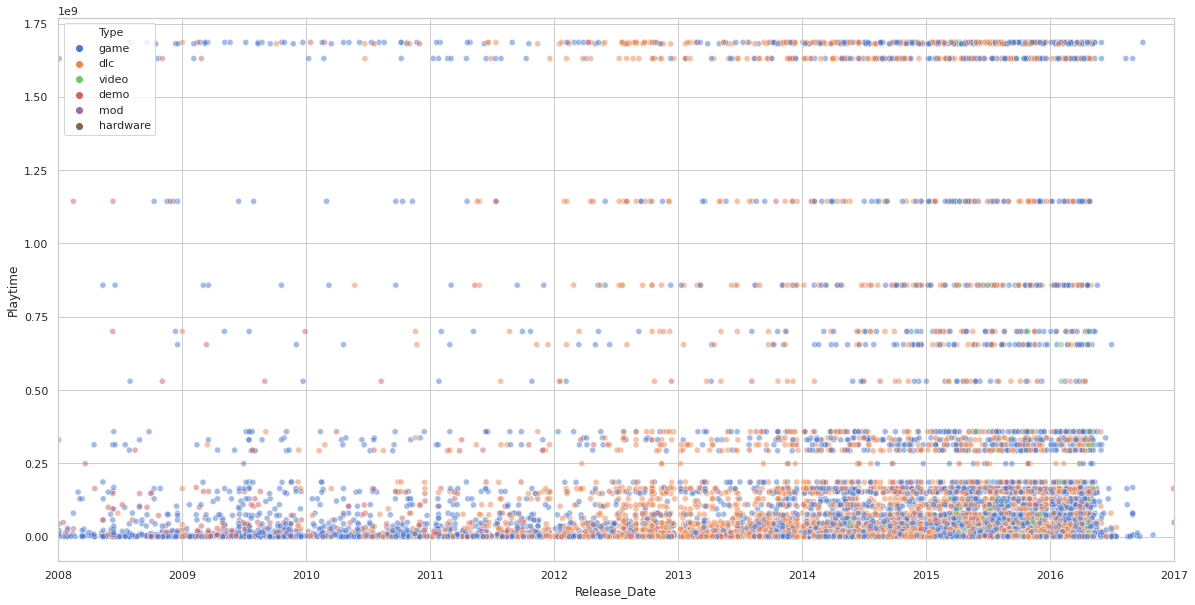

In [35]:
f10, ax10 = plt.subplots(figsize=(20, 10))
sns.scatterplot(x="Release_Date", y="Playtime", hue="Type", sizes=(100, 600), alpha=.5, palette="muted", ax=ax10, data=p2000plus) #size="weight",
ax10.set_xlim([pd.to_datetime("2008-01-01"), pd.to_datetime("2017-01-01")])

There was definetely a boom of DLCs being played during 2013 compared to games. Let's zoom in on 2012-2016 to confirm.

(734503.0, 735964.0)

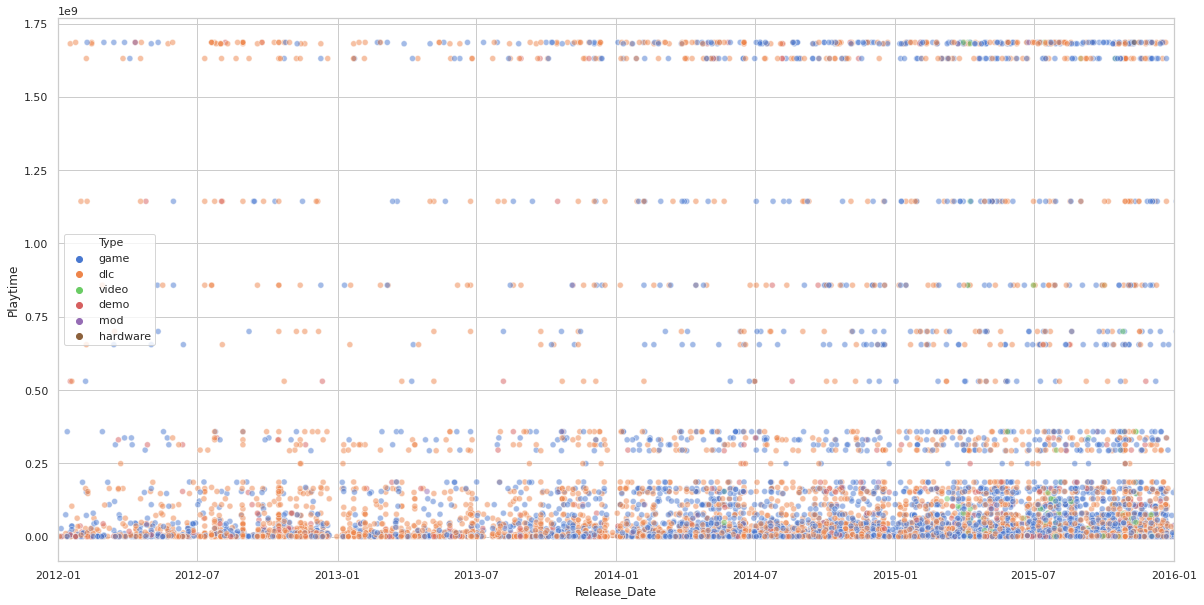

In [36]:
f10, ax10 = plt.subplots(figsize=(20, 10))
sns.scatterplot(x="Release_Date", y="Playtime", hue="Type", sizes=(100, 600), alpha=.5, palette="muted", ax=ax10, data=p2000plus) #size="weight",
ax10.set_xlim([pd.to_datetime("2012-01-01"), pd.to_datetime("2016-01-01")])

This clearly confirms the susposion, we can also see clear playtime paterns around Winter holliday times at years end - seems like a time to avoid games releases during that time! And it makes sense, why release when so many other games have discounts! Althouth it somewhat discipates in later years...

What about demos? (afaik these include alphas and pre-released products).

f10, ax10 = plt.subplots(figsize=(20, 10))
sns.scatterplot(x="Release_Date", y="Playtime", hue="Type", sizes=(100, 600), alpha=.5, palette="muted", ax=ax10, data=p2000plus) #size="weight",
ax10.set_xlim([pd.to_datetime("2012-01-01"), pd.to_datetime("2017-01-01")])

Let's see average prices per release per month

In [37]:
#games monthly means:
games_timed = games.copy()
#games_timed = products[products.Playtime > 0]
time_condition_1 = (pd.to_datetime(games_timed.Release_Date) > pd.to_datetime('2009-1-1'))
time_condition_2 = (pd.to_datetime(games_timed.Release_Date) < pd.to_datetime('2016-1-1'))
games_timed =  games_timed[time_condition_1 & time_condition_2]
games_timed.index = pd.to_datetime(games_timed['Release_Date'])
games_monthly_means = games_timed.groupby(pd.Grouper(freq='M')).mean()
games_monthly_means["Type"] = "Game"
games_monthly_means = games_monthly_means.reset_index()

In [38]:
#dlc monthly means:
dlcs_timed = dlcs.copy()
#games_timed = products[products.Playtime > 0]
time_condition_1 = (pd.to_datetime(dlcs_timed.Release_Date) > pd.to_datetime('2009-1-1'))
time_condition_2 = (pd.to_datetime(dlcs_timed.Release_Date) < pd.to_datetime('2016-1-1'))
dlcs_timed =  dlcs_timed[time_condition_1 & time_condition_2]
dlcs_timed.index = pd.to_datetime(dlcs_timed['Release_Date'])
dlcs_monthly_means = dlcs_timed.groupby(pd.Grouper(freq='M')).mean()
dlcs_monthly_means["Type"] = "DLC"
dlcs_monthly_means = dlcs_monthly_means.reset_index()

In [39]:
#dlc monthly means:
mods_timed = mods.copy()
#games_timed = products[products.Playtime > 0]
time_condition_1 = (pd.to_datetime(mods_timed.Release_Date) > pd.to_datetime('2009-1-1'))
time_condition_2 = (pd.to_datetime(mods_timed.Release_Date) < pd.to_datetime('2016-1-1'))
mods_timed =  mods_timed[time_condition_1 & time_condition_2]
mods_timed.index = pd.to_datetime(mods_timed['Release_Date'])
mods_monthly_means = mods_timed.groupby(pd.Grouper(freq='M')).mean()
mods_monthly_means["Type"] = "Mod"
mods_monthly_means = mods_monthly_means.reset_index()

In [40]:
products_timed_means = games_monthly_means.append([dlcs_monthly_means, mods_monthly_means])
products_timed_means = products_timed_means.dropna(subset=["Price"])
products_timed_means['Month'] = products_timed_means.index

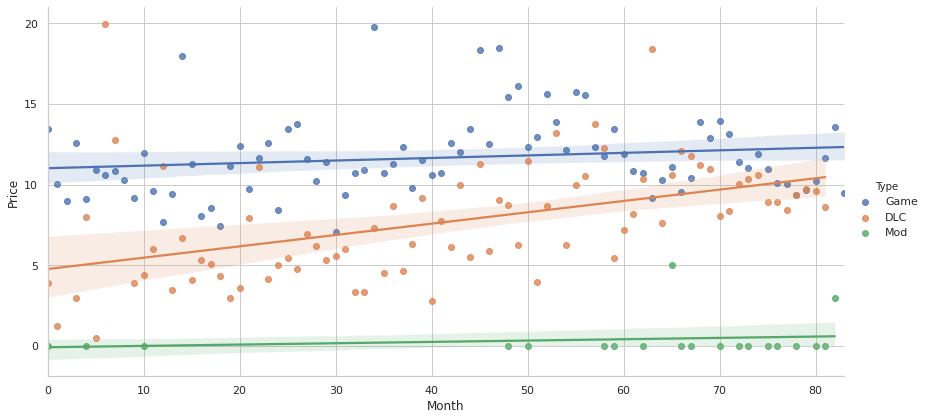

In [41]:
ax11 = sns.lmplot(x="Month", y="Price", hue = "Type", data=products_timed_means, height=6, aspect=2)

Sadly seaborn does not provide a slope value. There was a [big discussion](https://stackoverflow.com/questions/33490833/display-regression-equation-in-seaborn-regplot) after requesting such feature in 2015, but the author opposed. 
It is obvious however that all prices are going up - as it should be. The question is - do they go up faster than normal inflation? There is an interesting trend seen here, that DLC prices are increasing way faster, by today (2020), they must have definetely gone past regular game price. In no surprise we can se that some DLCs that come out today are priced higher than base game. This must be a natural mechanism of leveraging dlc-base monetization model to increase product price as well as overall gaining popularity of the pricing model.

### What rating tendencies are there?
* vs price
* vs units sold (or visa versa)
* vs total cumulative playtime

In [42]:
products_rating_plot = products[(products.Rating >= 0) & (products.Owners > 0)]

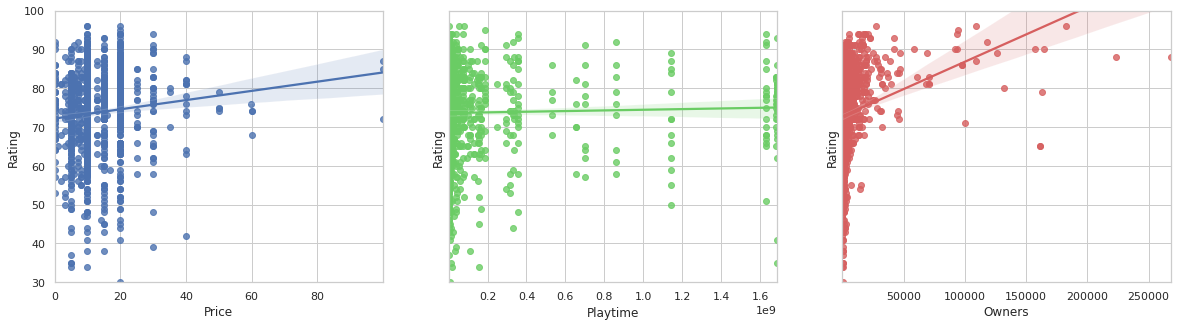

In [43]:
fig, (ax20, ax21, ax22) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20,5))
ax20.set_ylim(30,100) 

sns.regplot(x="Price", y="Rating", data=products_rating_plot, ax=ax20)
sns.regplot(x="Playtime", y="Rating", data=products_rating_plot, color="g", ax = ax21)
sns.regplot(x="Owners", y="Rating", data=products_rating_plot, color="r", ax = ax22)

Interestingely enough, higher rated games do not have a meaningfull tendenty to be played more. An obvious correlation here is rating vs price, but it is good to make a sanity check once in a while - it makes sense. However a new insight is the positive corelation of Rating vs Price. This could be usefull when making games!

## Genres available
* Filter and find a list of unique genres
* Find which genres have most products per title

In [44]:
genres_types = genres.Genre.unique()
genres_groups = genres.groupby("Genre")
genres_desc = genres_groups.describe()
key = ('appid','count')
genres_desc = pd.DataFrame(genres_desc[key])
genres_desc = genres_desc.sort_values(key, ascending=False)

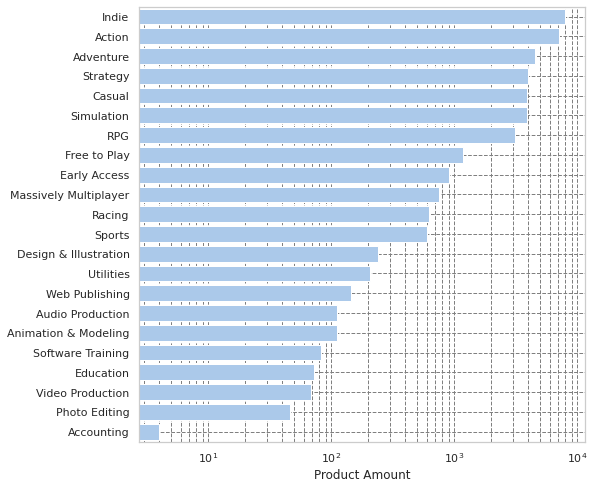

In [45]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(8, 8))
# First plot total value
sns.set_color_codes("pastel")
ent_val_graph = sns.barplot(x=key, y=genres_desc.index, data=genres_desc, label="Total", color="b", orient='h')
sns.set_color_codes("muted")

ax.set(ylabel="",xlabel="Product Amount")
ax.set_xscale("log")
ax.grid(True,which="both",ls="--",c='gray')  
plt.show()

* Show genre relation network


Since each product can have multiple genres selected by the publisher, this is a nice opportunity to visualize the relational network between genres.

In [46]:
import networkx as nx

In [49]:
genre_intersections = pd.DataFrame(columns=["Genre_A","Genre_B","Weight"])
keys = [key for key, _ in genres_groups]
for j in range(len(keys)):
    A_list = []
    B_list = []
    W_list = []
    for i in range(j+1, len(genres_groups)):
        weight = len(set(genres_groups.get_group(keys[j])["appid"]).intersection(set(genres_groups.get_group(keys[i])["appid"])))
        if weight > 0:
            A_list.append(keys[j])
            B_list.append(keys[i])
            W_list.append(weight)

    df = pd.DataFrame({"Genre_A":A_list, "Genre_B":B_list, "Weight":W_list})
    genre_intersections = genre_intersections.append(df)

genre_intersections["N_Weight"] = ((genre_intersections.Weight / (genre_intersections.Weight).max()) * 4) +0.2

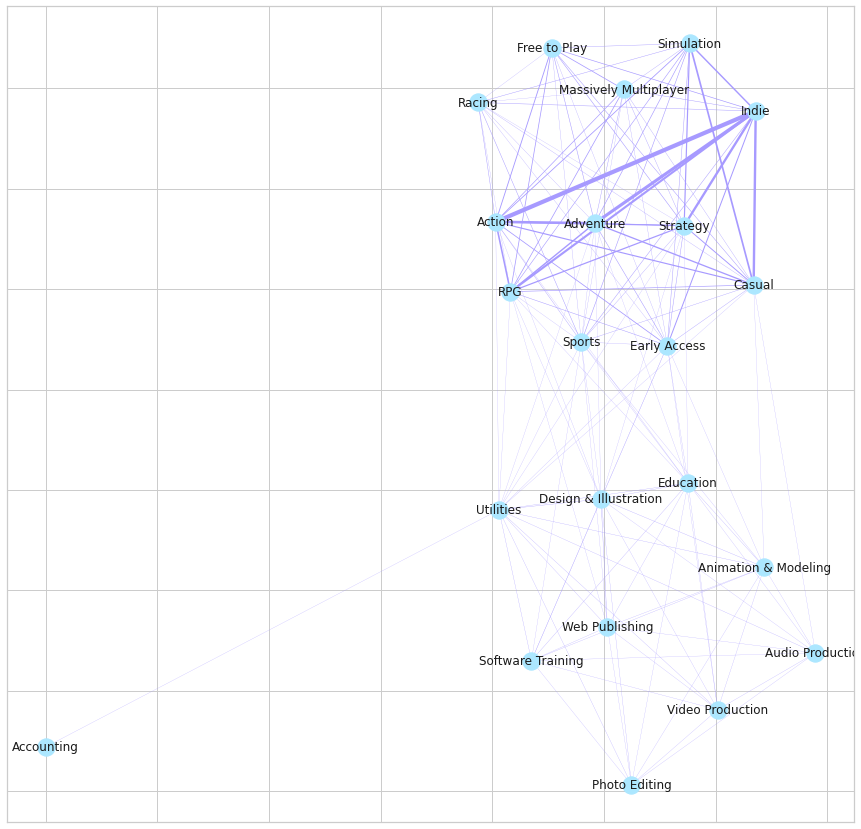

In [50]:
G = nx.from_pandas_edgelist(genre_intersections,'Genre_A','Genre_B', edge_attr='N_Weight')
durations = [i['N_Weight'] for i in dict(G.edges).values()]
labels = [i for i in dict(G.nodes).keys()]
labels = {i:i for i in dict(G.nodes).keys()}

fig, ax = plt.subplots(figsize=(12,15))
margin=0.01
fig.subplots_adjust(left=margin, right=1.0-margin)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, ax = ax, node_color='#ACE7FF', labels=True)
nx.draw_networkx_edges(G, pos, width=durations, edge_color='#A79AFF',ax=ax)
_ = nx.draw_networkx_labels(G, pos, labels, ax=ax)

As we could have already guessed Indie, Action and Adventure makes up the major triangle. Somewhet interesting to see two clusters of products formed:
1. Games
2. Education/training
3. Acounting is there too, wait what??

## World of Steam
* Show global map of all users, draw bigger markers on cities, where registered user amount is larger
* Find highest percentage of gamers vs population and plot a chloroplest map to visualize it - this doenst work, because population data missmatch gamer data. A lot of cities get 1000's of percentages, which of course is inacurate to say the least...

In [51]:
# This dataset is provided in GeoPandas
world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)

In [52]:
# Real data imports:
#PLAYER_SUMMARIES	steamid	loccountrycode	timecreated
players_data_link = "../input/steam-player-summaries/players_filtered.csv"
players = pd.read_csv(players_data_link).drop(['gameserverip', 'cityid', 'timecreated'], axis = 1).dropna(subset=["loccityid"])

In [53]:
# creating an embed function to visualize maps in all browsers
def embed_map(m, file_name):
    from IPython.display import IFrame
    m.save(file_name)
    return IFrame(file_name, width='100%', height='700px')

Then let's extract steam locale IDs. We do this by using a dataset (json format) shared in github by a user  Holek. Sadly, the json has multiple levels (and weird dictionary format too), so to form proper dataframes, we'll need to flatten them into lists first.

In [54]:
#prepare locale and coordinates, to be able to extract data from users locale, because steam uses its own id system. Not all entries have 'coordinates' data, so have to account for that later on...
import json 

def flatten_to_countries(json):
    output = []
    for country, val_c in json.items():
        if 'coordinates' in val_c.keys():
            row = {'country_ID' : country, 'Country': val_c['name'],'coordinates': val_c['coordinates']}
            output.append(row)
        else:
            row = {'country_ID' : country, 'Country': val_c['name'],'coordinates': ''}
    return output

def flatten_to_states(json):
    output = []
    for country, val_c in json.items():
        for state, val_s in json[country]['states'].items():
            if 'coordinates' in val_s.keys():
                row = {'state_ID':state, 'State': val_s['name'], 'country_ID':country, 'coordinates':val_s['coordinates']}
            else:
                row = {'state_ID':state, 'State': val_s['name'], 'country_ID':country, 'coordinates':''}
            output.append(row)

    return output

def flatten_to_cities(json):
    output = []
    for country, val_c in json.items():
        for state, val_s in json[country]['states'].items():
            for city, val_city in val_s['cities'].items():
                row = {'city_ID':city, 'City': val_city['name'].lower(), 'country_ID':country, 'state_ID':state}
                output.append(row)
    return output

st_countries_path = "../input/steam-countries/steam_countries.min.json"

with open(st_countries_path) as f:
    json_countries = json.load(f)
    flat_countries = flatten_to_countries(json_countries)
    flat_states = flatten_to_states(json_countries)
    flat_cities = flatten_to_cities(json_countries)
    
    countries_df = pd.DataFrame(flat_countries)
    states_df = pd.DataFrame(flat_states)
    cities_df = pd.DataFrame(flat_cities)

Holek has provided us with most of the coordinates, but sadly not all, so we will have to try matching the names of the cities to extract coordinates from world map data. Let's try filling missing city coordinates.

In [55]:
#prepare data for filling in missing coordinates
world_cities_pop_df = pd.read_csv("../input/world-cities-database/worldcitiespop.csv", low_memory=False)
#drop all rows which do not have a population in them. There are multiple rows like that for some reason in "worldcitiespop.csv"
world_cit_only_pop = world_cities_pop_df.dropna(subset=['Population'])
world_cities_pop_df = world_cities_pop_df[~world_cities_pop_df.City.isin(world_cit_only_pop.City)]
#add only unique values, so that we wont miss anything when joining into steam id's
world_cities_pop_df = pd.concat([world_cit_only_pop,world_cities_pop_df])

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [56]:
countries_df['Latitude'] = countries_df.coordinates.apply(lambda x: float(x.split(',')[0]) if x is not "" else None)
countries_df['Longitude'] = countries_df.coordinates.apply(lambda x: float(x.split(',')[1]) if x is not "" else None)
states_df['Latitude'] = states_df.coordinates.apply(lambda x: float(x.split(',')[0]) if x is not "" else None)
states_df['Longitude'] = states_df.coordinates.apply(lambda x: float(x.split(',')[1]) if x is not "" else None)
# merge steam ID table with world city coordinates
cities_merged_df = cities_df.merge(world_cities_pop_df[['City','Population',"Latitude",'Longitude']], on="City", how="inner")
cities_merged_df["City"] = cities_merged_df["City"].str.capitalize()

First, let's prepare and tidy up our data a bit:
* filter out unusable/missing data and change locale cell to a proper geocode / coordinates point
* group players by city ID, count their number and a column to city

In [57]:
players["loccityid"] = players["loccityid"].astype(int)
cities_merged_df["city_ID"] = cities_merged_df["city_ID"].astype(int)

In [58]:
players_groups = players.groupby(["loccityid"])
cities_merged_df["Players"] = players_groups.apply(lambda grp: grp.size)
cities_merged_df = cities_merged_df.dropna()
cities_merged_df["Gamer_Weight"] = 1.0 * cities_merged_df['Players'] / cities_merged_df['Population']

Since I am from Lithuania, I am interested in the data there. Numbers here are tiny and boring, probably not a lot of players input their city... I also added a 1000 top-population world cities.

In [61]:
LTs = cities_gdf[cities_gdf.country_ID == "LT"].sort_values(by="Players", ascending=False).iloc[:100]

In [62]:
cities_gdf = gpd.GeoDataFrame(cities_merged_df, geometry=gpd.points_from_xy(cities_merged_df.Latitude, cities_merged_df.Longitude))
m_1 = folium.Map(location=[54.899298, 23.888495], tiles='Stamen Toner', zoom_start=8)
top_1000_cities_gdf = cities_gdf.sort_values(by="Players", ascending=False).iloc[:1000]
top_1000_cities_gdf = top_1000_cities_gdf.append(LTs)
for i in range(0, len(top_1000_cities_gdf)):
    f_html = 'City: {}<br>Population: {:d}<br>Players: {:d}<br>Gamer Weight: {:.1%}'.format(top_1000_cities_gdf.iloc[i]['City'], int(top_1000_cities_gdf.iloc[i]['Population']), int(top_1000_cities_gdf.iloc[i]['Players']), top_1000_cities_gdf.iloc[i]['Gamer_Weight'])
    popup = folium.Popup(
        f_html,
        max_width=200,
        min_width=200)
    folium.CircleMarker(
        location=[top_1000_cities_gdf.iloc[i]['geometry'].x, top_1000_cities_gdf.iloc[i]['geometry'].y],
        radius=((top_1000_cities_gdf.iloc[i]["Players"]/1000)**(1/2)), #
        color='#3186cc',
        fill=True,
        fill_color='#3186cc',
        popup = popup
        ).add_to(m_1)

Original idea was to show a heatmap, where heavier areas would be shown where there's a higher 'Gamer weight'. Sadly world citizen data is inconsistent compared to player data, thus showing in some towns as much as 6000% steam users related to population, which of course is impossible. I've left the value for anyone who's interested, though the sizes are adjusted via player count value in town.

If you are viewing in github the map will not be displayed. You can go to kaggle and see the [original notebook and view the map](https://www.kaggle.com/danieliusv/steam-game).

In [65]:
m_1
#embed_map(m_1, "m_1.html")

We can find some interesting trends here, although some nationalities obviously tend to not reveal their data too much (or at all).

What would be top 10 cities/towns in lithuania by gamer count and gamer percentage?

Hint: those are quite tiny cities/towns.

In [66]:
LT_Players = LTs.nlargest(10, "Players")
LT_Gamer_Weight = LTs.nlargest(10, "Gamer_Weight")
multi_table([LT_Players[['City','Players']], LT_Gamer_Weight[['City','Gamer_Weight']]])

City,Players
Rusne,1936.0
Utena,1904.0
Palanga,1736.0
Priekule,1316.0
Vilnius,924.0
Jieznas,828.0
Ezerelis,804.0
Sirvintos,688.0
Daugai,672.0
Vilkija,668.0


# Conclusions
Bear in mind the data is 4 years old, which is equivalent to barely usable - since then we've had a whole new section of games emerge. I mean, of course, VR/AR. Steam also had major tech and policy updates since.
1. With publishers it seems that more releases reward with more owners proportionally, but developers mostly are concentrated on a smaller amount of releases and cases where they would have a lot are rare.
2. Most developers on steam self-publish.
3. Most top rated developers and even publishers received a conciderably large part of their revenue from a single title.
4. Developers and publishers avoid releasing games on world-wide holliday seaons.
5. Higher priced products tend to also be also higher rated.
6. DLC montly-mean prices are increasing over time quite steadily.

## Further Exploration
A lot of interesting insights could be done, but the scope of this notebook is at an end. Here I list some of the ideas that I decided not to implement in this case due to time constraints, but perhaps could do later, i.e. if I obtained new data from Steam some time in the future.

#### DLC demand
* Count additional products for each title (app id) and add a column into a dataframe.
* How many dlcs per product count changes historically?


#### Kickstarter succcess on Steam
* Find and generate kickstarter game publishers who has their game on Steam. There is data to identify which products were started through KS available on Kaggle.
* Calculate and plot their value and playtime, check genre distributions.


#### Genre value
* Most valuable game genre on Steam.
* Most selective audience is of the G2 genre - uniquely concentrated around L0 location.
* Highest non-English language-genre pair is L1-G3.
* Plot "Weighted o
wners" of each genre.

#### Genre clusters
* Find the global value of each Genre / Tag which (products * owners * price).
* Show how global value changed of top 3 most common genres over time.
* Find most common genre * tags combo.
* Show sum global values of top 5 most common combos.

#### Game genre popularity and dispersion
* Filter owners of each game genre and show top 3 genres world heatmaps.
* Find the genre with smallest dispersion of it's users.
* Show top language of users for each genre (do same excluding and including english to compare).